EcoSVDD/FISVDD code,

Owen Howell, July 15, 2019
olh20@bu.edu, https://owenhowell20.github.io

Optimized linear EcoSVDD code
In case of norm 1 kernel K( x, x) = 1 reduces to FISVDD algorithm: https://arxiv.org/abs/1709.00139
In paper we focus on kernel functions K(x,x) = 1, however this code works for any kernel function K(x,y)

This code runs EcoSVDD algoritm and compares with batch SVDD
It produces Figure 7 in the paper


In [1]:
#Import standard python packages
import numpy as np 	
import matplotlib.pyplot as plt
import sys

#QP is done with CVXOPT packages
from cvxopt import matrix, solvers
import numpy as np
solvers.options['show_progress'] = False 


#A global error threshold, any small number can be used
thresh = 1e-3



In [2]:
#Generate data from a gaussian distribution
#Returns dataset
def generate_data(N, dimension):


	#The mean of the distribtuion
	mean  = np.random.uniform( 0.5, 0.5, dimension)

	#The covarience matrix of the distribution

	cov = np.zeros([dimension,dimension])

	for i in range(dimension):
		cov[i,i] = .01

	xvals = np.random.multivariate_normal(mean,cov,N)

	return xvals

In [3]:
#The kernel function
def kernel(x,y):

	#using a gaussian kernel
	sigma = 1.0

	return np.exp(   -1* np.dot( ( x - y  ) , ( x - y  ) ) /(2*sigma )  )


In [4]:
#Intilize the EcoSVDD, compute support vectors for first N_start points
#Inputs are the datapoints
#Returns the set of active datapoints, support vector values
def EcoSVDD_initialize(xvals):

	N_start = len(xvals[:,0])
 
	#Function to generate the intial kernel matrix
	def intial_kernel_matrix():

		#Compute the intial kernel matrix
		Qmat = np.zeros([N_start,N_start])

		for i in range(N_start):
			for j in range(N_start):

				
				s =  kernel(xvals[i,:],xvals[j,:])

				Qmat[i,j] = 2.0*s

		return Qmat

	Qmat = intial_kernel_matrix()

	#Convert to CVXOPT format
	Q = matrix(Qmat)

	p = np.zeros(N_start)
	for i in range(N_start):
		p[i] = - kernel(xvals[i,:],xvals[i,:])

	p = matrix(p)

	G = np.zeros([N_start,N_start])
	for i in range(N_start):
		G[i,i] = -1

	G = matrix(G)

	h = np.zeros([N_start])
	h = matrix(h)

	A = np.zeros(N_start)
	for i in range(N_start):
		A[i] = 1

	A = matrix(A,(1,N_start),'d')

	b = matrix(1.0)

	sol =  solvers.qp(Q, p, G, h, A, b)

	#the intial values of solution
	#KKT values a_{i}
	KKT = np.array( sol['x'] )


	#only care about non-zero values
	for i in range(N_start):
		if (KKT[i] < thresh) :
			KKT[i] = 0

	#Only need to keep non-zero KKT values, also know as support vectors
	#Find intial support vector values and support vector indices
	support_vects_inds = np.array( np.ndarray.nonzero(KKT)[0] )
	support_vects = KKT[support_vects_inds]

	#the set of active datapoints
	active_data_x = intial_xvals[support_vects_inds,:]

	#Check that there is at least one active support vector

	if (   len(support_vects_inds) == 0 ):

		print("Not enough intial points, no active support vector found. Make sure adaquate kernel function is used")
		quit()


	return active_data_x, support_vects

In [5]:

#Run the EcoSVDD algorithm on a single new point
#Inputs are datapoint X,  active datapoints, set of support vectors and the dataset dimension
#Returns the new set of data points and the new set of support vectors
def point_Run_EcoSVDD( X, active_data_x , support_vects , dimension  ):

	
	numsupportvects = len(active_data_x[:,0])

	#sum varible
	s = 0
	
	for i in range(numsupportvects):

		Qval = kernel( X , active_data_x[i,:]  ) - kernel( active_data_x[0,:] , active_data_x[i,:]  )

		s = s + Qval*support_vects[i]
	

	#Compute the invasion condition
	inv = kernel( X, X  ) - kernel( active_data_x[0,:] , active_data_x[0,:]  )  - s

	if (inv>=0):

		#The new species can invade. Recompute the steady state using QP

		Qp = np.zeros([numsupportvects+1,numsupportvects+1])


		for i in range(numsupportvects):
			for j in range(numsupportvects):

					s = kernel(active_data_x[i,:],active_data_x[j,:])

					Qp[i,j] = 2*s

		for i in range(numsupportvects):

			s = kernel(active_data_x[i,:], X)

			Qp[i,numsupportvects] = 2*s

			Qp[numsupportvects,i] = 2*s
		

		s = kernel(X,X)
	
		Qp[numsupportvects,numsupportvects] = 2*s

		Qp = matrix(Qp)

		p = np.zeros(numsupportvects+1)

		for i in range(numsupportvects):
			p[i] = - kernel(active_data_x[i,:],active_data_x[i,:])


		p[numsupportvects] = - kernel(  X, X  )


		p = matrix(p)


		G = np.zeros([numsupportvects+1,numsupportvects+1])
		for i in range(numsupportvects+1):
			G[i,i] = -1
		G = matrix(G)


		h = np.zeros([numsupportvects+1])
		h = matrix(h)


		A = np.zeros(numsupportvects+1)
		for i in range(numsupportvects):
			A[i] = 1

		A[numsupportvects] = 1
		A = matrix(A,(1,numsupportvects+1),'d')

		b = matrix(1.0)

		#Call QP function
		sol =  solvers.qp(Qp, p, G, h, A, b)

		#QP solution as array, all KKT values
		KKT = np.array( sol['x'] )

		#Get the new support vector indices and values
		#only care about non-zero support vectors
		countnew = 0
		for i in range(len(KKT)):
			if (KKT[i] < thresh):
				KKT[i] = 0
				countnew = countnew + 1

		countnew = len(KKT) -  countnew
		

		#the set of new support vectors and support vector indices
		new_active_data_x = np.zeros([countnew, dimension])
		newsuppvects = np.zeros([countnew])


		auxcount = 0
		auxcount2 = 0
		for i in range(len(KKT)-1):

			if (KKT[i] > thresh):
				new_active_data_x[auxcount,:] = active_data_x[auxcount2,:]				

				newsuppvects[auxcount] = KKT[i]
				auxcount = auxcount + 1
				auxcount2 = auxcount2 + 1

			if (KKT[i]<thresh):
				auxcount2 = auxcount2 + 1



		if (KKT[len(KKT)-1]>thresh):

			new_active_data_x[auxcount,:] = X

			newsuppvects[auxcount] = KKT[len(KKT)-1]
			auxcount = auxcount + 1

		
		#New support vector values and indices
		support_vects = newsuppvects

		#zero array because it can change shape
		active_data_x = np.zeros( [len(support_vects) , dimension ] )
		active_data_x = new_active_data_x

	
	return active_data_x, support_vects

In [6]:

#Run the EcoSVM algorithm
#Inputs are datapoints and intial support vector values
#Returns the set of active datapoints, the support vector values
def Run_EcoSVDD( xvals, active_data_x, support_vects  ):

	#the dataset dimension
	dimension = len(xvals[0,:])

	#Run the EcoSVM algorithm over all points
	for point in range(N_start,N):

		X = xvals[point,:]

		#Run the EcoSVM algorithm on a single point
		active_data_x, support_vects = point_Run_EcoSVDD( X , active_data_x , support_vects, dimension )

	
	return active_data_x, support_vects 


In [7]:

#Run a batch SVDD on all data
#Input is all training data
#Output is the set of active datapoints and support vector values
def batchSVDD( xvals  ):

	#the number of datapoints
	N = len(xvals[:,0])

	#the full kernel matrix for batch SVM
	Qfull = np.zeros([N,N])

	for i in range(N):
		for j in range(N):

			#using a linear kernel
			s =  kernel(xvals[i],xvals[j])

			Qfull[i,j] = 2*s

	#The full batch SVM solution with QP	
	#Convert into CVXOPT format

	Qf = matrix(Qfull)

	pf = np.zeros(N)

	for i in range(N):
		pf[i] = -kernel(xvals[i,:],xvals[i,:])

	pf = matrix(pf)


	Gf = np.zeros([N,N])
	for i in range(N):
		Gf[i,i] = -1

	Gf = matrix(Gf)

	hf = np.zeros([N])
	hf = matrix(hf)

	Af = np.zeros(N)
	for i in range(N):
		Af[i] = 1

	Af = matrix(Af,(1,N),'d')

	bf = matrix(1.0)

	sol =  solvers.qp(Qf, pf, Gf, hf, Af, bf)

	evars = np.array( sol['x'] )


	#only care about non-zero support vectors
	for i in range(N):
		if (evars[i] < thresh):
			evars[i] = 0


	#Find support vectors and support vector indices for Batch SVM
	supvectsindsfull = np.array( np.ndarray.nonzero(evars)[0] )
	supvectsfull = evars[supvectsindsfull]

	active_data_x = xvals[ supvectsindsfull ,:]
	
	return active_data_x, supvectsfull


In [8]:

#Function to get the radius of the trained SVDD
#Inputs are active data and set of support vectors
#Returns the SVDD radius
def get_radius(active_data_x,support_vects):

	dists = np.zeros([len(support_vects)])

	for i in range(len(support_vects)):

		d1 = 0
		d2 = 0	

		for j in range(len(support_vects)):

			d1  = d1 + kernel( active_data_x[i,:] , active_data_x[j,:]  ) * support_vects[j]
		
			for k in range(len(support_vects)):

				d2 = d2 + kernel( active_data_x[j,:] , active_data_x[k,:]  ) * support_vects[j] * support_vects[k]



		dists[i] = kernel( active_data_x[i,:] , active_data_x[i,:]  ) - 2*d1  + d2


		R = np.sqrt(  min(dists)   )

	return R


In [9]:

#A similiarity metric between two SVDDs
#Returns the normilized dot product of the two SVDD sphere centers
def sim_metric( active_data_x, support_vects, batch_data_x, batch_support_vects  ):

	lenth_1 = len(support_vects)
	lenth_2 = len(batch_support_vects)

	val = 0

	for i in range(lenth_1):
		for j in range(lenth_2):

			val = val + support_vects[i]*batch_support_vects[j] * kernel( active_data_x[i,:] , batch_data_x[j,:]  )


	norm1 = 0
	for i in range(lenth_1):
		for j in range(lenth_1):

			norm1 = norm1 + support_vects[i]*support_vects[j] * kernel( active_data_x[i,:], active_data_x[j,:]  )


	norm2 = 0
	for i in range(lenth_2):
		for j in range(lenth_2):

			norm2 = norm2 + batch_support_vects[i]*batch_support_vects[j] * kernel( batch_data_x[i,:], batch_data_x[j,:]  )

	
	metric = val / np.sqrt(  norm1 * norm2 ) 
	metric = np.float(metric)
	return metric

In [10]:

#Function to make prediction plots
#See main text for detail
#only make plots in two dimensions
def make_plot():

	#Only make plots for two dimensional data
	if (dimension!=2):
		quit()

	#plot all train datapoints
	for i in range(100):


		plt.plot(xvals[i,0],xvals[i,1],'.',c='k',marker='X',markersize=8,markeredgecolor='black')

	
	for i in range(len(batch_support_vects)):

		plt.plot(batch_data_x[i,0],batch_data_x[i,1],'.',c='r',marker='P',markersize=22,markeredgecolor='black')


	#also plot active support vectors in larger markers
	for i in range(len(support_vects)):
	
		plt.plot(active_data_x[i,0],active_data_x[i,1],'.',c='g',marker='*',markersize=22,markeredgecolor='black')

	import matplotlib.lines as mlines
	blue_star = mlines.Line2D([], [], color='green', marker='*', linestyle='None', markersize=10, label='EcoSVDD Support Vectors')
	red_square = mlines.Line2D([], [], color='red', marker='P', linestyle='None', markersize=10, label='Batch Support Vectors')
	purple_triangle = mlines.Line2D([], [], color='black', marker='X', linestyle='None', markersize=10, label='Datapoints')

	plt.legend(handles=[blue_star, red_square, purple_triangle])

	fontsize = 22
	
	plt.ylim(0,1)
	plt.xlim(0,1)
	plt.grid()
	plt.tick_params(labelsize=fontsize-5)
	plt.xlabel("$X_{1}$",size=fontsize)
	plt.ylabel("$X_{2}$",size = fontsize)


	from pylab import rcParams
	rcParams['figure.figsize'] = 500, 500

	plt.tight_layout()

	plt.show()


EcoSVDD radius: 0.3576937294490513
Batch SVDD radius: 0.35769376919073426
Eco SVDD and Batch SVDD simularity score: 0.9999999999999971


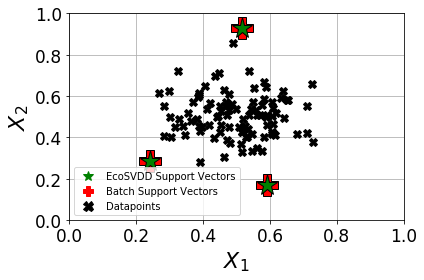

In [11]:

#These parameters are chosen to create a dataset
#Dimension of the dataset
dimension = 2

#Total number of training points
N = 500


#Get train dataset, this can be also be user entered
xvals = generate_data(N,dimension)

#the number of intial points
N_start = 20

#the intial datapoints and labels
intial_xvals = xvals[0:N_start,:]


#Get the intial set of active datapoints, support vector values and the Lagrange multiplier
intial_active_data_x, intial_support_vects = EcoSVDD_initialize(intial_xvals)


#Run the EcoSVM algorithm on the dataset
active_data_x, support_vects = Run_EcoSVDD( xvals, intial_active_data_x, intial_support_vects   )


#Get the full batch solution to compare
batch_data_x,  batch_support_vects = batchSVDD( xvals )


radius = get_radius(  active_data_x, support_vects  )
batch_radius = get_radius( batch_data_x, batch_support_vects  )

#the final radius
print('EcoSVDD radius:',  radius)
print('Batch SVDD radius:',  batch_radius)

metric = sim_metric( active_data_x, support_vects, batch_data_x, batch_support_vects  )

#the simularity score
print('Eco SVDD and Batch SVDD simularity score:', metric)

make_plot()